In [2]:
import datetime
import warnings
from collections import defaultdict

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from bokeh.io import output_file, output_notebook, show
from bokeh.layouts import gridplot
from bokeh.models import Circle, ColorBar, FixedTicker, FuncTickFormatter, LinearColorMapper, MultiLine
from bokeh.plotting import figure, from_networkx
from bokeh.resources import settings

# View interactive network graph in Jupyter Notebook
output_notebook()
settings.resources = "inline"

# Set seaborn white theme
sns.set_theme(style="white")
sns.set_palette("rocket")

# Remove warnings
warnings.filterwarnings("ignore")

Loading BokehJS ...

In [3]:
areas = ["Asia", "Europe", "India", "Northen America"]
area_color = {
	"Asia": "#b56576",
	"Europe": "#6d597a",
	"India": "#eaac8b",
	"Northen America": "#355070"
}
area_palette = {area: sns.light_palette(area_color[area], reverse=True, as_cmap=True) for area in areas}
area_palette_4 = {area: sns.light_palette(area_color[area], reverse=True, n_colors=4) for area in areas}

In [4]:
# Define the paths
DATA_PATH = "data/"
CLEAN_DATA_PATH = "clean_data/"

In [5]:
# Load the data
movies_df = pd.read_csv(CLEAN_DATA_PATH + "movies.csv")
characters_df = pd.read_csv(CLEAN_DATA_PATH + "characters.csv")
ethnicities_df = pd.read_csv(CLEAN_DATA_PATH + "etnicity_labels.csv")

In [6]:
# actor_age is the age at which the actor played the role, but we wand the actor's current age
print(f"Age of 'Frank Welker': {characters_df[characters_df['actor_name'] == 'Frank Welker']['actor_age'].values[0]}")
print(f"Birth date of 'Frank Welker': {characters_df[characters_df['actor_name'] == 'Frank Welker']['actor_birth_date'].values[0]}")

Age of 'Frank Welker': 30.0
Birth date of 'Frank Welker': 1946-03-12


In [7]:
# Remove the missing data for actor_birth_date
print(f"Percentage of missing data for actor_birth_date: {round(characters_df['actor_birth_date'].isna().sum() / len(characters_df) * 100, 2)}% ({characters_df['actor_birth_date'].isna().sum()} out of {len(characters_df)})")
characters_df = characters_df[characters_df["actor_birth_date"].notna()]

Percentage of missing data for actor_birth_date: 23.55% (106145 out of 450669)


In [8]:
def is_too_old(row, max_age):
    # If age is not available, use birth date
    if pd.notna(row["actor_birth_date"]):
        current_year = datetime.datetime.now().year
        try:
            birth_year = datetime.datetime.strptime(row["actor_birth_date"], "%Y-%m-%d").year
        except:
            try:
                birth_year = datetime.datetime.strptime(row["actor_birth_date"], "%Y-%m").year
            except:
                try:
                    birth_year = datetime.datetime.strptime(row["actor_birth_date"], "%Y").year
                except:
                    return True
        return current_year - birth_year > max_age

    # If both age and birth date are missing, assume too old
    return True


# Remove the actors that are already too old (older than {max_age} years old)
max_age = 70
num_actors_before_filter = len(characters_df)
characters_df = characters_df[~characters_df.apply(lambda row: is_too_old(row, max_age), axis=1)]
num_removed = num_actors_before_filter - len(characters_df)
print(f"{num_removed / num_actors_before_filter * 100:.2f}% ({num_removed} out of {num_actors_before_filter}) of the actors are older than {max_age} years old and have been removed.")

56.11% (193310 out of 344524) of the actors are older than 70 years old and have been removed.


In [9]:
# Filter the characters that have no name
num_characters_before_filter = len(characters_df)
characters_df = characters_df.dropna(subset=["actor_name"])
num_removed = num_characters_before_filter - len(characters_df)
print(f"{num_removed / num_characters_before_filter * 100:.2f}% ({num_removed} out of {num_characters_before_filter}) of the characters have no name and have been removed.")

0.00% (4 out of 151214) of the characters have no name and have been removed.


In [10]:
# Group the movies by area
movies_df = {area: movies_df[movies_df["area"] == area] for area in areas}

# Merge the characters with the movies
movies_characters_df = {}
for area in areas:
    movies_characters_df[area] = pd.merge(characters_df, movies_df[area], left_on="movie_id", right_on="id")
    movies_characters_df[area] = movies_characters_df[area].drop(columns=["id_y"])
    movies_characters_df[area] = movies_characters_df[area].rename(columns={"name_x": "character_name", "name_y": "movie_name", "id_x": "character_id", "id_y": "movie_id"})

display(movies_characters_df["Northen America"].head())

,movie_wiki_id,movie_id,movie_release_date,character_name,actor_birth_date,actor_gender,actor_height,actor_ethinicity_id,actor_name,actor_age,...,character_id,actor_id,movie_release_year,wiki_id,movie_name,release_date,revenue,runtime,area,release_year
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,...,/m/0bgcj3x,/m/03wcfv7,2001,975900,Ghosts of Mars,2001-08-24,14010832.0,98.0,Northen America,2001.0
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,...,/m/0bgchn4,/m/0346l4,2001,975900,Ghosts of Mars,2001-08-24,14010832.0,98.0,Northen America,2001.0
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,...,/m/0bgchn_,/m/01vw26l,2001,975900,Ghosts of Mars,2001-08-24,14010832.0,98.0,Northen America,2001.0
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,...,/m/0bgchnq,/m/034hyc,2001,975900,Ghosts of Mars,2001-08-24,14010832.0,98.0,Northen America,2001.0
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,...,/m/0bgchp9,/m/01y9xg,2001,975900,Ghosts of Mars,2001-08-24,14010832.0,98.0,Northen America,2001.0


In [11]:
# Pre-compute mapping from actor_name to movie_id, and vice versa
actor_name_to_movie_ids = {area: defaultdict(set) for area in areas}
movie_id_to_actor_names = {area: defaultdict(set) for area in areas}
for area in areas:
    for _, row in movies_characters_df[area].iterrows():
        actor_name_to_movie_ids[area][row["actor_name"]].add(row["movie_id"])
        movie_id_to_actor_names[area][row["movie_id"]].add(row["actor_name"])

In [12]:
# Create a graph of every actor and add a connection between them if they have acted together in a movie
actor_graph = {area: nx.Graph() for area in areas}
connections = {area: defaultdict(int) for area in areas}
for area in areas:
    for movie_id in movie_id_to_actor_names[area]:
        actors = movie_id_to_actor_names[area][movie_id]
        for actor1 in actors:
            for actor2 in actors:
                if actor1 != actor2:
                    connections[area][actor1] += 1
                    connections[area][actor2] += 1
                    actor_graph[area].add_edge(actor1, actor2)

# Sort the actors by the number of connections
sorted_connections = {area: sorted(connections[area].items(), key=lambda x: x[1], reverse=True) for area in areas}
print("Top 10 actors with the most connections in 'Northen America':")
for actor, num_connections in sorted_connections["Northen America"][:10]:
    print(f" - {actor}: {num_connections}")

Top 10 actors with the most connections in 'Northen America':
 - Bruce Willis: 1382
 - Steve Buscemi: 1270
 - Ben Stiller: 1198
 - Keith David: 1140
 - Christopher McDonald: 1060
 - Nicolas Cage: 1030
 - Jack Black: 1022
 - David Koechner: 1014
 - John Turturro: 1008
 - Stanley Tucci: 1006


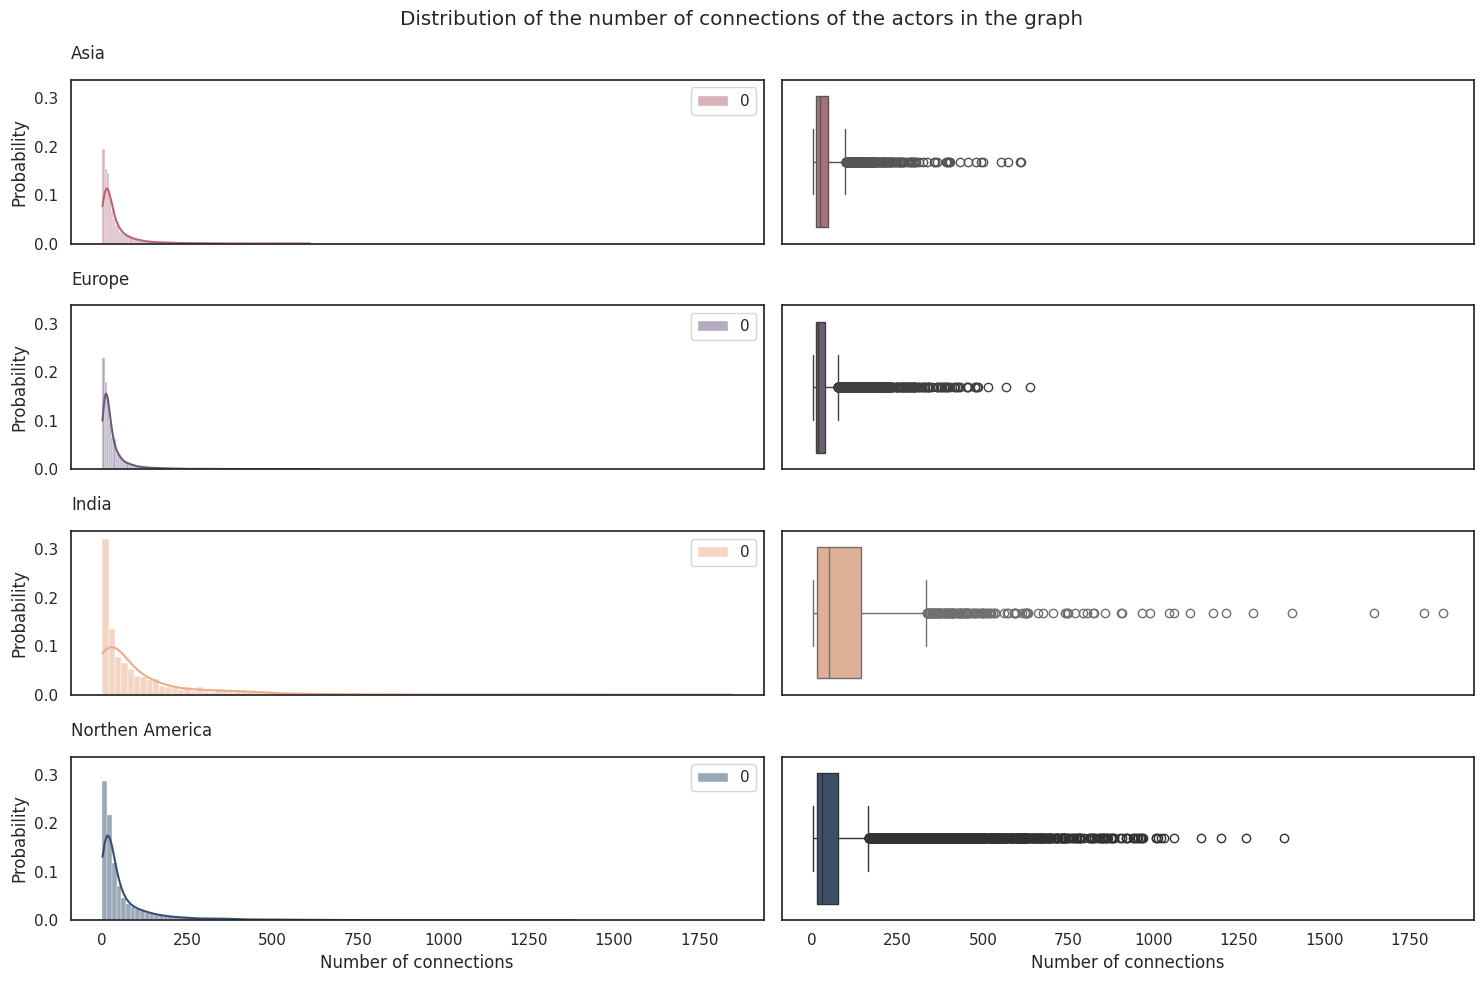

In [13]:
# Plot the distribution of the number of connections
fig, axs = plt.subplots(4, 2, figsize=(15, 10), sharex="col", sharey="col")
fig.suptitle("Distribution of the number of connections of the actors in the graph")

for i, area in enumerate(areas):
    # Plot the histogram of the number of connections
    sns.histplot(connections[area].values(), kde=True, ax=axs[i][0], stat="probability", bins=100, palette=area_palette_4[area])
    axs[i][0].set_title(f"{area}", loc="left", pad=15)
    axs[i][0].set_xlabel("Number of connections")
    axs[i][0].set_ylabel("Probability")

    # Plot the boxplot of the number of connections
    sns.boxplot(x=list(connections[area].values()), ax=axs[i][1], color=area_color[area])
    axs[i][1].set_xlabel("Number of connections")

plt.tight_layout()
plt.show()

In [14]:
# Remove {quantile}% of the actors with the least connections
quantile = 0.98
filtered_actor_graph = {}
filtered_connections = {}
for area in areas:
    # Compute the minimum number of connections
    num_min_connections = int(pd.Series(connections[area]).quantile(quantile))
    num_actors_before_filter = len(connections[area])

    # Remove the actors with the least connections of the graph
    actors_to_remove = set(actor for actor in connections[area] if connections[area][actor] <= num_min_connections)
    filtered_actor_graph[area] = actor_graph[area].copy()
    filtered_actor_graph[area].remove_nodes_from(actors_to_remove)
    filtered_connections[area] = {actor: connections[area][actor] for actor in connections[area] if actor not in actors_to_remove}

    print(f"\n{area}:")
    print(f"There are {num_actors_before_filter - len(actors_to_remove)} actors left over {num_actors_before_filter} with the least connections ({(quantile) * 100}% quantile).")
    print(f"Minimum number of connections: {num_min_connections}")


Asia:
There are 59 actors left over 2917 with the least connections (98.0% quantile).
Minimum number of connections: 212

Europe:
There are 154 actors left over 7885 with the least connections (98.0% quantile).
Minimum number of connections: 180

India:
There are 28 actors left over 1366 with the least connections (98.0% quantile).
Minimum number of connections: 630

Northen America:
There are 339 actors left over 16963 with the least connections (98.0% quantile).
Minimum number of connections: 472


In [15]:
def get_color_from_value(value, palette, value_min=0, value_max=1):
    value = max(min(value, value_max), value_min)
    index = int((value - value_min) / (value_max - value_min) * (len(palette) - 1))
    index = max(min(index, len(palette) - 1), 0)
    return palette[index]


def rgb_to_hex(rgb):
    return f"#{int(rgb[0]*255):02x}{int(rgb[1]*255):02x}{int(rgb[2]*255):02x}"


num_groups = 8
plots = {}

for area in areas:
    # Copy the graph
    render_graph = filtered_actor_graph[area].copy()

    # Group the actors by the number of connections into {num_groups} groups
    size_max = max(filtered_connections[area].values())
    size_min = min(filtered_connections[area].values())
    group_ranges = np.linspace(size_min, size_max, num=num_groups + 1, dtype=int)
    group_range_labels = [f"{group_ranges[i+1]}-{group_ranges[i]}" for i in range(num_groups)]

    actor_to_group = defaultdict(int)
    for actor, num_connections in filtered_connections[area].items():
        actor_to_group[actor] = np.searchsorted(group_ranges, num_connections) - 1

    # Set the node attributes
    sns_palette_8 = sns.light_palette(area_color[area], reverse=True, n_colors=num_groups)
    bokeh_palette_8 = [rgb_to_hex(rgb) for rgb in sns_palette_8][::-1]
    for actor in render_graph.nodes:
        render_graph.nodes[actor]["size"] = actor_to_group[actor] * 2 + 10
        render_graph.nodes[actor]["color"] = get_color_from_value(actor_to_group[actor], bokeh_palette_8, 0, num_groups - 1)
        render_graph.nodes[actor]["group"] = actor_to_group[actor]
        render_graph.nodes[actor]["connections"] = filtered_connections[area][actor]
        render_graph.nodes[actor]["name"] = actor

    # Map the actor names to indices (for bokeh)
    actor_to_index = {actor: index for index, actor in enumerate(render_graph.nodes)}
    render_graph = nx.relabel_nodes(render_graph, actor_to_index)

    # Create a bokeh plot
    title = f"Network graph of the most important actors in {area}"
    hover_tooltips = [("Name", "@name"), ("Connections", "@connections"), ("Group", "@group")]
    plot = figure(title=title, tooltips=hover_tooltips, tools="pan,wheel_zoom,save,reset", active_scroll="wheel_zoom")

    # Add color bar
    color_mapper = LinearColorMapper(palette=bokeh_palette_8, low=0, high=num_groups - 1)
    ticker = FixedTicker(ticks=np.arange(0, num_groups))
    formatter = FuncTickFormatter(
        code="""
        var labels = %s;
        return labels[tick];
    """
        % group_range_labels
    )
    color_bar = ColorBar(color_mapper=color_mapper, ticker=ticker, label_standoff=12, formatter=formatter)
    plot.add_layout(color_bar, "right")

    # Network graph rendering
    bokeh_graph = from_networkx(render_graph, nx.spring_layout, scale=2, center=(0, 0))
    bokeh_graph.node_renderer.glyph = Circle(size="size", fill_color="color")
    bokeh_graph.edge_renderer.glyph = MultiLine(line_alpha=0.1, line_width=0.5)
    plot.renderers.append(bokeh_graph)

    # Save the plot
    # output_file(f"{area} connection graph.html".replace(" ", "_"))
    plots[area] = plot

# Show the plots
grid_plot = gridplot([plots[area] for area in areas], ncols=2)
show(grid_plot)

In [16]:
display(characters_df.head())

,movie_wiki_id,movie_id,movie_release_date,name,actor_birth_date,actor_gender,actor_height,actor_ethinicity_id,actor_name,actor_age,actor_map_id,id,actor_id,movie_release_year
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,2001
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,2001


In [17]:
# Remove {quantile}% of the actors with the least connections
quantile = 0.95
filtered_actresses = {}
filtered_connections = {}
for area in areas:
	# Only keep the actresses in the connections
	filtered_actresses[area] = movies_characters_df[area][movies_characters_df[area]["actor_gender"] == "F"]
	actresses_names = set(filtered_actresses[area]["actor_name"].unique())
	filtered_connections[area] = {actor: connections[area][actor] for actor in connections[area] if actor in actresses_names}

	# Compute the minimum number of connections
	num_min_connections = int(pd.Series(filtered_connections[area]).quantile(quantile))
	num_actors_before_filter = len(filtered_connections[area])

	# Remove the actresses with the least connections
	actors_to_remove = set(actor for actor in filtered_connections[area] if filtered_connections[area][actor] <= num_min_connections)
	filtered_actresses[area] = filtered_actresses[area][~filtered_actresses[area]["actor_name"].isin(actors_to_remove)]
	filtered_connections[area] = {actor: filtered_connections[area][actor] for actor in filtered_connections[area] if actor not in actors_to_remove}

	print(f"\n{area}:")
	print(f"There are {num_actors_before_filter - len(actors_to_remove)} actresses left over {num_actors_before_filter} with the least connections ({(quantile) * 100}% quantile).")
	print(f"Minimum number of connections: {num_min_connections}")


Asia:
There are 68 actresses left over 1378 with the least connections (95.0% quantile).
Minimum number of connections: 116

Europe:
There are 157 actresses left over 3236 with the least connections (95.0% quantile).
Minimum number of connections: 102

India:
There are 33 actresses left over 674 with the least connections (95.0% quantile).
Minimum number of connections: 386

Northen America:
There are 326 actresses left over 6505 with the least connections (95.0% quantile).
Minimum number of connections: 289


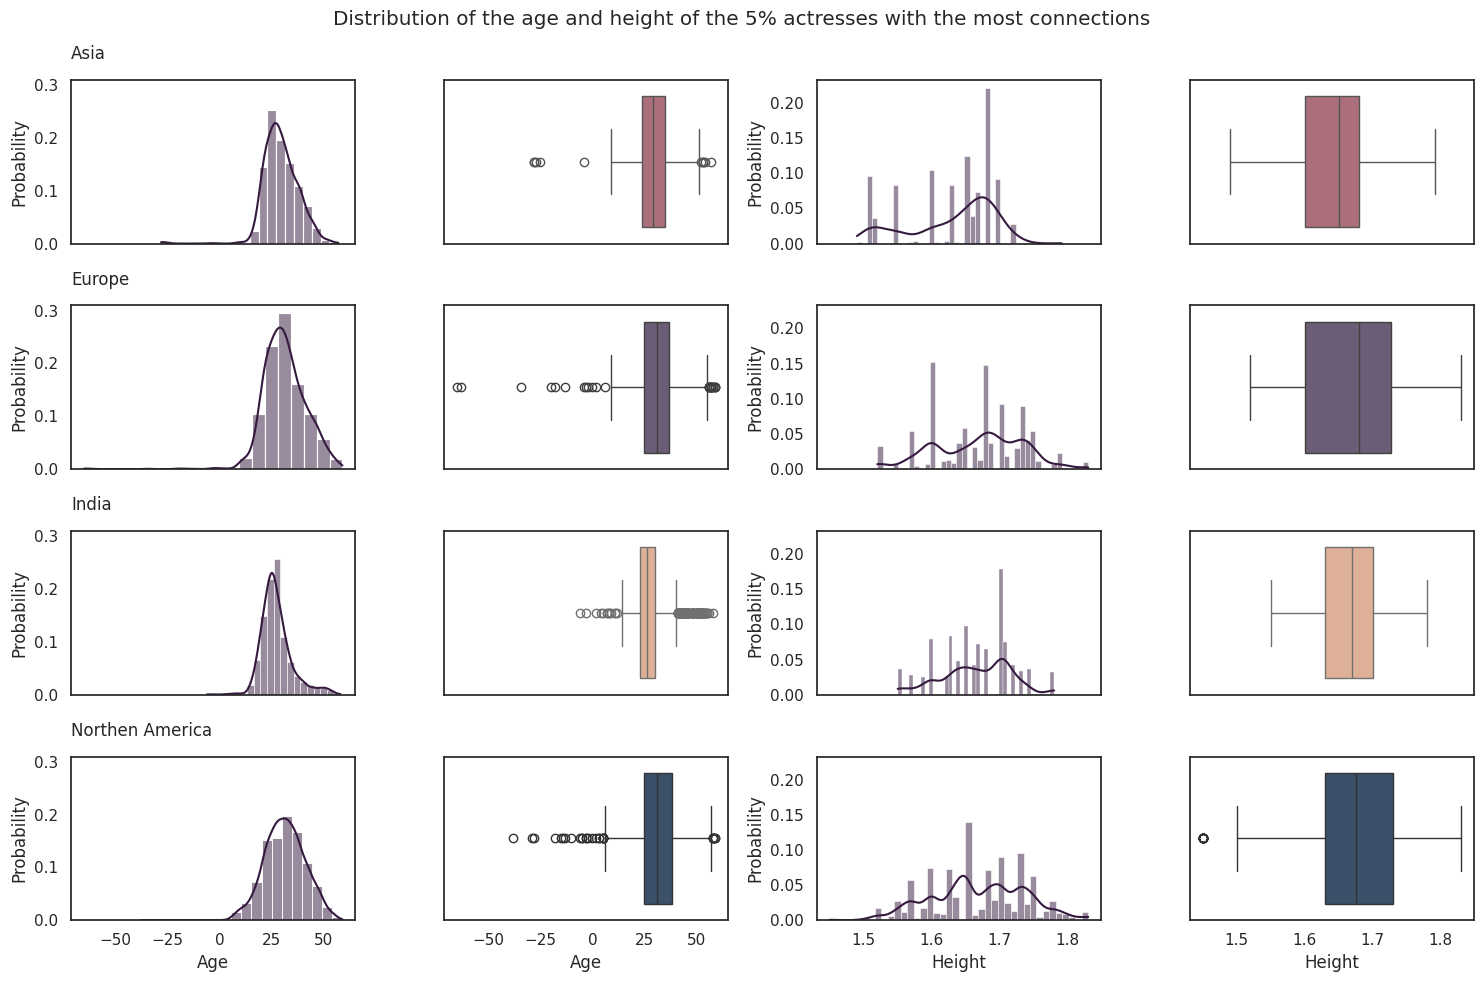

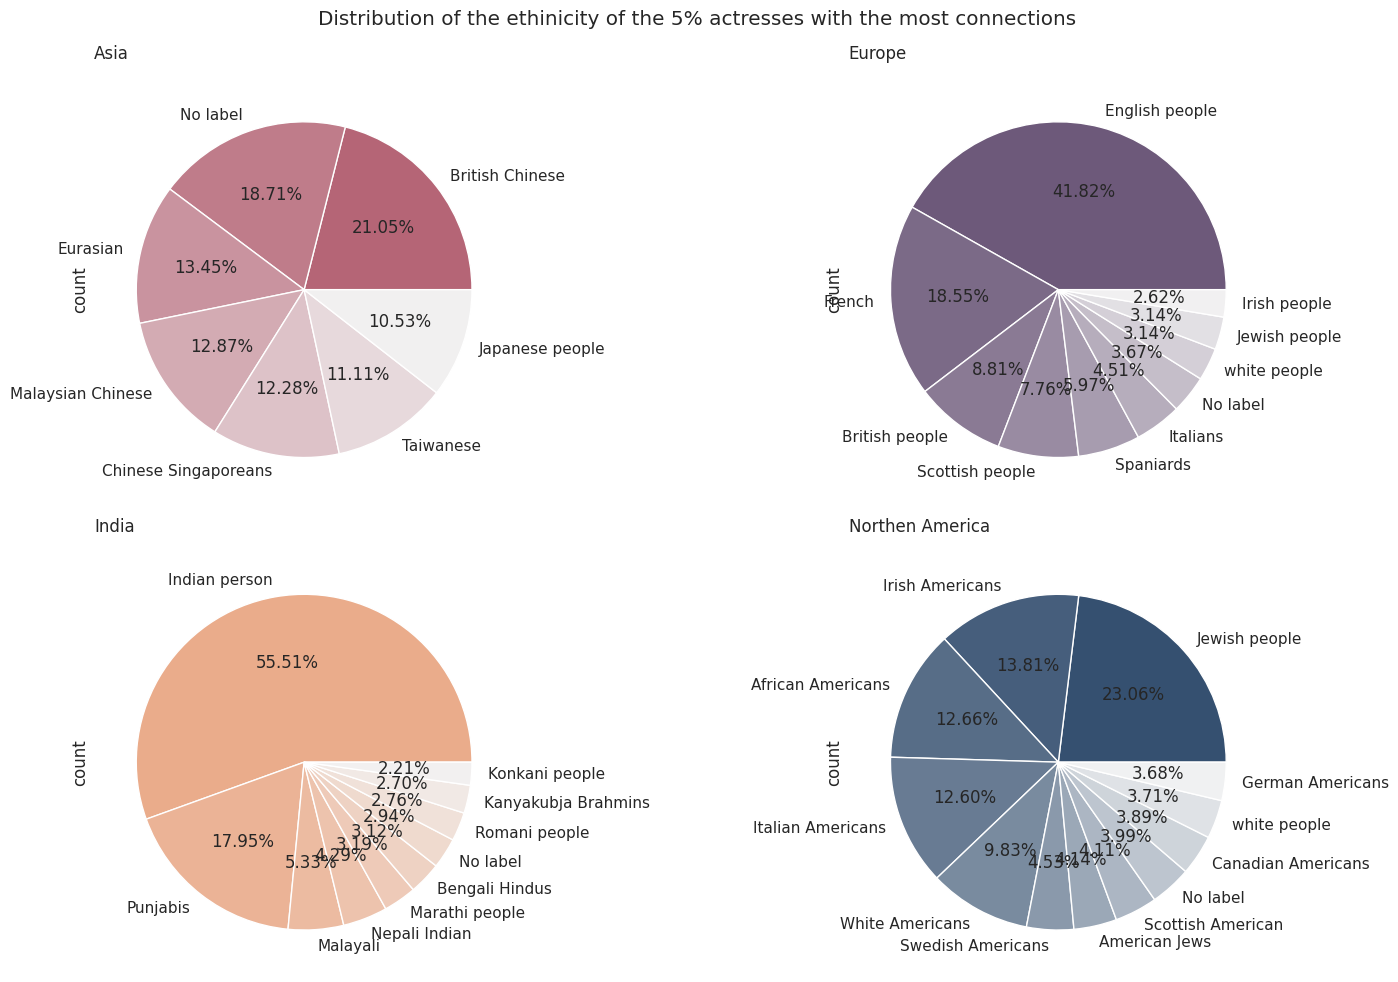

In [28]:
# Plot the distribution of the age and height
fig, axs = plt.subplots(4, 4, figsize=(15, 10), sharex="col", sharey="col")
fig.suptitle(f"Distribution of the age and height of the {(1 - quantile) * 100:.0f}% actresses with the most connections")

for i, area in enumerate(areas):
	# Plot the histogram of the age
	sns.histplot(filtered_actresses[area]["actor_age"], kde=True, ax=axs[i][0], stat="probability", bins=20, palette=area_palette_4[area])
	axs[i][0].set_title(f"{area}", loc="left", pad=15)
	axs[i][0].set_xlabel("Age")
	axs[i][0].set_ylabel("Probability")

	# Plot the boxplot of the age
	sns.boxplot(x=filtered_actresses[area]["actor_age"], ax=axs[i][1], color=area_color[area])
	axs[i][1].set_xlabel("Age")

	# Plot the histogram of the height
	sns.histplot(filtered_actresses[area]["actor_height"], kde=True, ax=axs[i][2], stat="probability", bins=40, palette=area_palette_4[area])
	axs[i][2].set_xlabel("Height")
	axs[i][2].set_ylabel("Probability")

	# Plot the boxplot of the height
	sns.boxplot(x=filtered_actresses[area]["actor_height"], ax=axs[i][3], color=area_color[area])
	axs[i][3].set_xlabel("Height")

plt.tight_layout()
plt.show()

# Plot the distribution of ethnicity
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(f"Distribution of the ethinicity of the {(1 - quantile) * 100:.0f}% actresses with the most connections")

for i, area in enumerate(areas):
	ethnicity_ids = filtered_actresses[area]["actor_ethinicity_id"]
	ethnicities = pd.merge(ethnicity_ids, ethnicities_df, on="actor_ethinicity_id")["ethnicity_Label"]
	ethnicity_counts = ethnicities.value_counts()
	ethnicity_counts = ethnicity_counts / ethnicity_counts.sum()
	ethnicity_counts = ethnicity_counts[ethnicity_counts > 0.02]
	ethnicity_counts = ethnicity_counts.sort_values(ascending=False)
	palette = sns.light_palette(area_color[area], reverse=True, n_colors=len(ethnicity_counts))
	ethnicity_counts.plot.pie(ax=axs[i // 2][i % 2], autopct="%.2f%%", colors=palette)
	axs[i // 2][i % 2].set_title(f"{area}", loc="left", pad=15)

plt.tight_layout()
plt.show()